# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: data/.DS_Store          
   creating: data/cells/
  inflating: data/cells/.DS_Store    
   creating: data/cells/labels/
  inflating: data/cells/labels/BMMC_10.bmp  
  inflating: data/cells/labels/BMMC_11.bmp  
  inflating: data/cells/labels/BMMC_12.bmp  
  inflating: data/cells/labels/BMMC_13.bmp  
  inflating: data/cells/labels/BMMC_14.bmp  
  inflating: data/cells/labels/BMMC_15.bmp  
  inflating: data/cells/labels/BMMC_16.bmp  
  inflating: data/cells/labels/BMMC_17.bmp  
  inflating: data/cells/labels/BMMC_18.bmp  
  inflating: data/cells/labels/BMMC_20.bmp  
  inflating: data/cells/labels/BMMC_21.bmp  
  inflating: data/cells/labels/BMMC_22.bmp  
  inflating: data/cells/labels/BMMC_23.bmp  
  inflating: data/cells/labels/BMMC_24.bmp  
  inflating: data/cells/labels/BMMC_25.bmp  
  inflating: data/cells/labels/BMMC_27.bmp  
  inflating: data/cells/labels/BMMC_28.bmp  
  inflating: data/cells/labels/BMMC_34.bmp  
  inflating: data/cells/labels/BMMC_35

#Defining the Dataset Class

In [3]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = 'True', train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()
    # todo
    #initialize the data class
    self.data_dir = data_dir
    self.size = size
    self.augment_data = augment_data
    self.image_dir = os.path.join(data_dir, 'scans')
    self.label_dir = os.path.join(data_dir, 'labels')
    self.images = os.listdir(self.image_dir)
    self.labels = os.listdir(self.label_dir)

    if train == 'True':
      self.images = self.images[:int(train_test_split*len(self.images))]
      self.labels = self.labels[:int(train_test_split*len(self.labels))]
    else:
      self.images = self.images[int(train_test_split*len(self.images)):]
      self.labels = self.labels[int(train_test_split*len(self.labels)):]

    self.ts = transforms.Compose([
                transforms.Resize((size,size)),
                transforms.ToTensor(),
            ])
    
    self.ts2 = transforms.Compose([
                transforms.Resize((size,size)),
                transforms.PILToTensor(),
            ]) 
    


  def __getitem__(self, idx):
      # todo

      #load image and mask from index idx of your data
      image_name = self.images[idx]
      label_name = self.labels[idx]
      #image = Image.open(image_name)
      
      image = Image.open(os.path.join(self.image_dir, image_name))
      #label = Image.open(label_name)
      label = Image.open(os.path.join(self.label_dir, label_name))
      

      image = self.ts(image)
      label = self.ts2(label)
      
      #data augmentation part
      if self.augment_data:
        augment_mode = np.random.randint(0, 4)
        if augment_mode == 0:
          #todo 
          #flip image vertically
          image = TF.vflip(image)
          label = TF.vflip(label)
        elif augment_mode == 1:
          #todo
          #flip image horizontally
          image = TF.hflip(image)
          label = TF.hflip(label)
        elif augment_mode == 2:
          #todo
          #zoom image
          image = TF.adjust_gamma(image, 1.5, gain=1)
          #label = TF.adjust_gamma(label, 1.5, gain=1)
        else:
          #todo
          #rotate image
          image = TF.rotate(image, 45)
          label = TF.rotate(label, 45)


      #todo
      #return image and mask in tensors
      
      #########################################
      image = image.squeeze(0)
      label = label.squeeze(0)
      #########################################
      return image, label
      
      

  def __len__(self):
    return len(self.images)


#Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [4]:
class twoConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(twoConvBlock, self).__init__()
    #todo
    #initialize the block

    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )

  def forward(self, x):
    #todo
    #implement the forward path
    return self.conv_block(x)


class downStep(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(downStep, self).__init__()
    #todo
    #initialize the down path
    self.down = nn.Sequential(
        nn.MaxPool2d(2),
        twoConvBlock(in_channel, out_channel)
    )

  def forward(self, x):
    #todo
    #implement the forward path
    return self.down(x)


class upStep(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(upStep, self).__init__()
    #todo
    #initialize the up path
    self.up = nn.ConvTranspose2d(in_channels=in_channel, out_channels=int(in_channel/2), kernel_size=2, stride=2)
    self.conv = twoConvBlock(in_channel, out_channel)
    

  def forward(self, x1, x2):
    #todo
    #implement the forward path 
    x1 = self.up(x1)
    #######################################
    crop = transforms.Compose([
            transforms.CenterCrop((x1.size()[2],x1.size()[3])),
            ])
    x2 = crop(x2)
    #######################################
    x = torch.cat([x1, x2], dim=1)
    
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    #todo
    #initialize the complete model
    self.start_block = twoConvBlock(1, 64)
    self.down1 = downStep(64, 128)
    self.down2 = downStep(128, 256)
    self.down3 = downStep(256, 512)
    self.down4 = downStep(512, 1024)
    self.up1 = upStep(1024, 512)
    self.up2 = upStep(512, 256)
    self.up3 = upStep(256, 128)
    self.up4 = upStep(128, 64)
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)

  def forward(self, x):
    #todo
    #implement the forward path
    x1 = self.start_block(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    
    #x4 = x4[:,:,4:x4.shape[2]-4,4:x4.shape[2]-4]
    
    x = self.up1(x5, x4)
    
    #x3 = x3[:,:,16:x3.shape[2]-16,16:x3.shape[2]-16]
    x = self.up2(x, x3)
    
    #x2 = x2[:,:,40:x2.shape[2]-40,40:x2.shape[2]-40]
    x = self.up3(x, x2)
    
    #x1 = x1[:,:,88:x1.shape[2]-88,88:x1.shape[2]-88]
    
    x = self.up4(x, x1)
    x = self.final_layer(x)
    
    
    return x





#Training

batch 0 --- Loss: 0.1658
batch 1 --- Loss: 0.1459
batch 2 --- Loss: 0.1377
batch 3 --- Loss: 0.1255
batch 4 --- Loss: 0.1040
batch 5 --- Loss: 0.1230
batch 6 --- Loss: 0.1265
batch 7 --- Loss: 0.0841
Epoch 1 / 20 --- Loss: 0.1350
Accuracy: 0.5628 ---- Loss: 0.1645
batch 0 --- Loss: 0.1502
batch 1 --- Loss: 0.0953
batch 2 --- Loss: 0.1300
batch 3 --- Loss: 0.1387
batch 4 --- Loss: 0.1916
batch 5 --- Loss: 0.1311
batch 6 --- Loss: 0.1260
batch 7 --- Loss: 0.1331
Epoch 2 / 20 --- Loss: 0.1461
Accuracy: 0.7363 ---- Loss: 0.1463
batch 0 --- Loss: 0.1625
batch 1 --- Loss: 0.1717
batch 2 --- Loss: 0.1097
batch 3 --- Loss: 0.1470
batch 4 --- Loss: 0.0950
batch 5 --- Loss: 0.1473
batch 6 --- Loss: 0.1163
batch 7 --- Loss: 0.1323
Epoch 3 / 20 --- Loss: 0.1442
Accuracy: 0.4498 ---- Loss: 0.1804
batch 0 --- Loss: 0.1150
batch 1 --- Loss: 0.2008
batch 2 --- Loss: 0.0876
batch 3 --- Loss: 0.0995
batch 4 --- Loss: 0.0997
batch 5 --- Loss: 0.1358
batch 6 --- Loss: 0.1836
batch 7 --- Loss: 0.0899
Epoch

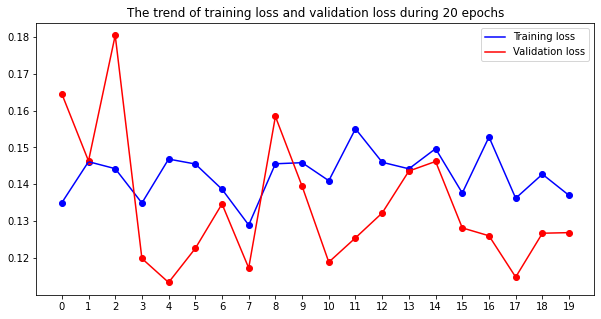

In [18]:
#Paramteres

#learning rate
lr = 1e-2

#number of training epochs
epoch_n = 20

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')


trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = 4, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = 4)

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to('cuda:0').to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=0.0005)
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

train_loss = []
validation_loss = []

model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data
    #print(image.shape)
    ####################################################
    image = image.unsqueeze(1).to(device)
    #image = image.to(device)
    #######################################################
    label = label.long().to(device)
    

    pred = model(image)
    
    ###########################################
    #label = label.squeeze(1)
    ###########################################
    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]
    
    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))

  train_loss.append(epoch_loss / trainset.__len__())

  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data
      ###############################################
      image = image.unsqueeze(1).to(device)
      #image = image.to(device)
      ###############################################
      label = label.long().to(device)

      pred = model(image)
      ###########################################
      #label = label.squeeze(1)
      ###########################################
      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    validation_loss.append(total_loss / testset.__len__())

plt.figure(figsize=(10, 5))
plt.plot(train_loss, color='b', label='Training loss')
plt.plot(validation_loss, color='r', label='Validation loss')
plt.scatter(np.arange(len(train_loss)),train_loss, color='b')
plt.scatter(np.arange(len(train_loss)),validation_loss, color='r')
plt.legend()
plt.title("The trend of training loss and validation loss during 20 epochs")
plt.xticks(np.arange(len(train_loss)))
plt.show()
    



#Testing and Visualization

In [19]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)
    
    ##################################################################
    input_image = image.unsqueeze(0).unsqueeze(0).to(device)
    #input_image = image.unsqueeze(0).to(device)
    ###################################################################
    pred = model(input_image)
    #print(pred.max(),"pred")
    #print(labels.shape)
    #######################################################
    #labels = labels.squeeze(0)  # self added
    #######################################################
    
    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()
    

    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2

    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    
    output_masks.append(output_mask)
    output_labels.append(labels)
    
    #output_masks.append(input_image.cpu().squeeze(0).squeeze(0).numpy())


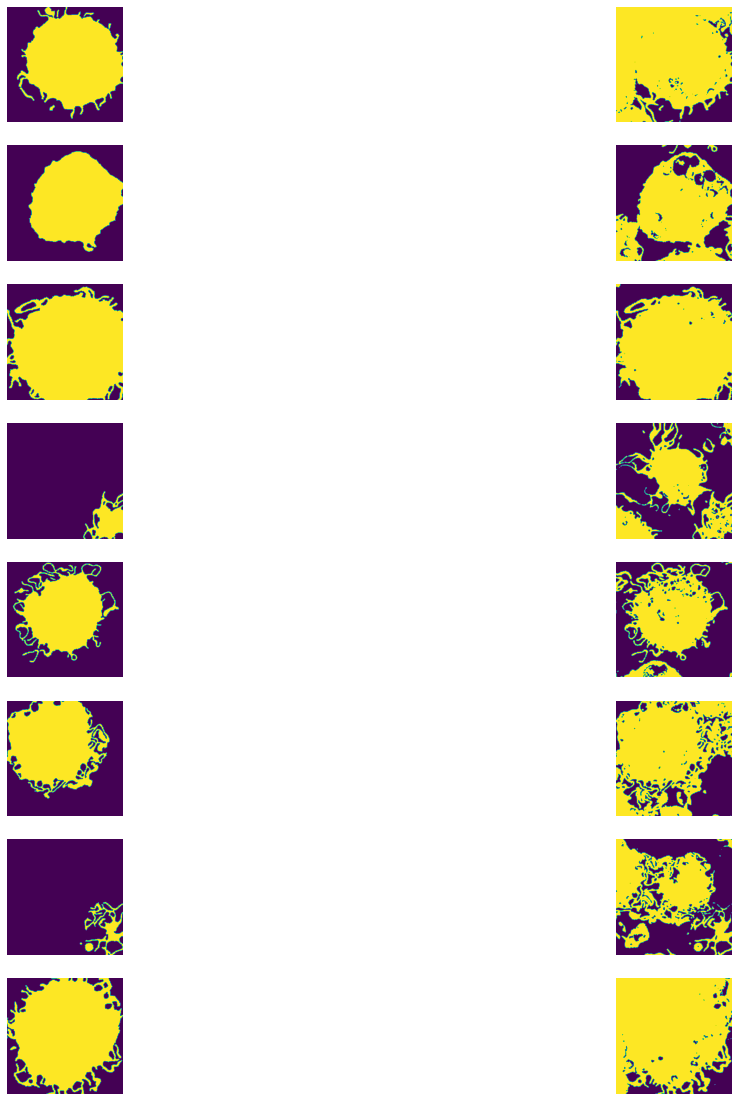

In [20]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')